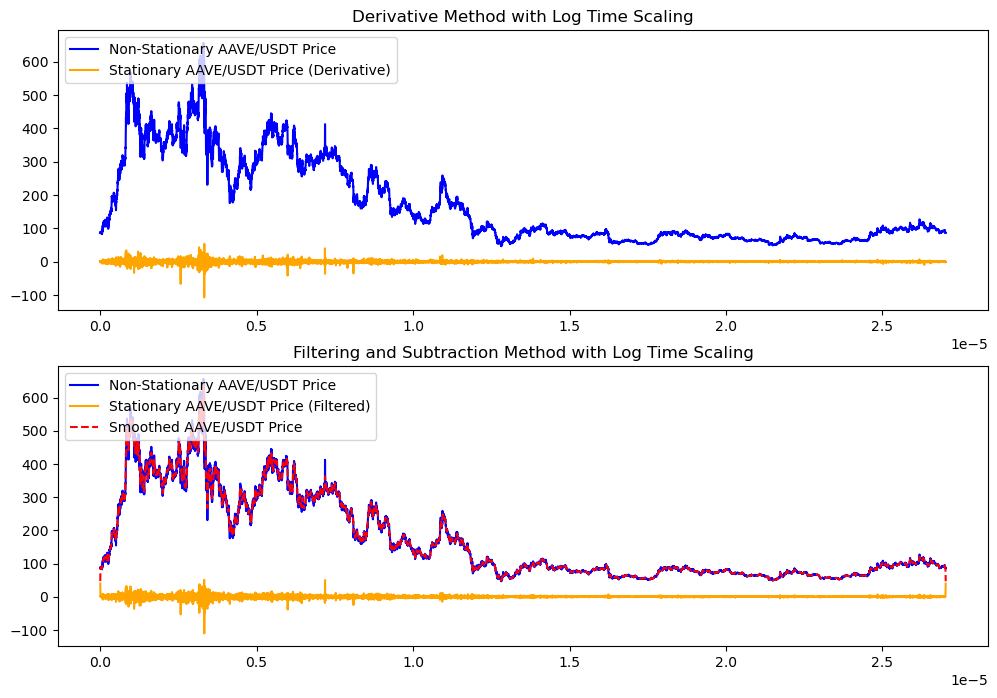

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# ======= Load dataset =======
file_path = "fixed_AAVEUSDT_hourly.csv"  # Ensure correct file path
df = pd.read_csv(file_path)

# Convert timestamp to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"], errors='coerce')

# Compute log time difference
df["log_time_diff"] = np.log1p((df["timestamp"] - df["timestamp"].min()).dt.total_seconds())

# Extract the closing prices
price = df["close"].dropna().values

# ======= 1️ Method 1: Derivative Method (Differencing) =======
price_dt = price[1:] - price[:-1]  # First-order differencing

# ======= 2️ Method 2: Gaussian Filtering Method (PyTorch) =======
filter_width = 12

def gaussian_kernel_1d(filter_width):
    sigma = (filter_width) / 2.33  # 99% of the values within this range
    norm = 1.0 / (np.sqrt(2*np.pi) * sigma)
    kernel = [norm * np.exp((-1)*(x**2)/(2 * sigma**2)) for x in range(-filter_width, filter_width + 1)]
    kernel = np.array(kernel, dtype=np.float32)
    return kernel / np.sum(kernel)  # Normalize

# Convert price data to PyTorch tensor
price_tensor = torch.tensor(price, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, T]

# Create Gaussian kernel
gaussian_kernel = torch.tensor(gaussian_kernel_1d(filter_width), dtype=torch.float32).unsqueeze(0).unsqueeze(0)

# Apply 1D convolution using PyTorch
filtered_price = F.conv1d(price_tensor, gaussian_kernel, padding='same').squeeze().numpy()

# Compute zero-centered price by subtracting the smoothed signal
price_centered = price - filtered_price

# Create time-shifted array for plotting (using log time difference)
time_shifted_log = df["log_time_diff"].iloc[1:].values  # Shift to match differenced data length

# ======= Plot Comparison with Log Time Difference =======
fig, axes = plt.subplots(2, figsize=(12, 8))

# Plot 1: Derivative Method
axes[0].plot(time_shifted_log, price[:-1], label="Non-Stationary AAVE/USDT Price", color='blue')
axes[0].plot(time_shifted_log, price_dt, label="Stationary AAVE/USDT Price (Derivative)", color='orange')
axes[0].set_title('Derivative Method with Log Time Scaling')
axes[0].legend(loc="upper left")

# Plot 2: Gaussian Filtering & Subtraction Method
axes[1].plot(df["log_time_diff"], price, label="Non-Stationary AAVE/USDT Price", color='blue')
axes[1].plot(df["log_time_diff"], price_centered, label="Stationary AAVE/USDT Price (Filtered)", color='orange')
axes[1].plot(df["log_time_diff"], filtered_price, label="Smoothed AAVE/USDT Price", color='red', linestyle="--")
axes[1].set_title('Filtering and Subtraction Method with Log Time Scaling')
axes[1].legend(loc="upper left")

plt.show()


In [20]:
import requests
import pandas as pd

# Define time range: from February 1, 2023 to February 10, 2023
start_date = "2025-02-01"
end_date = "2025-02-10"

# Convert to Unix timestamps in seconds
start_timestamp = int(pd.Timestamp(start_date).timestamp())
end_timestamp = int(pd.Timestamp(end_date).timestamp())

# CoinGecko API endpoint for market chart range data
url = "https://api.coingecko.com/api/v3/coins/aave/market_chart/range"

# Define parameters: vs_currency as usd, from and to timestamps
params = {
    "vs_currency": "usd",
    "from": start_timestamp,
    "to": end_timestamp
}

# Make the API request
response = requests.get(url, params=params)
print("Status Code:", response.status_code)

if response.status_code != 200:
    print("Error:", response.text)
else:
    data = response.json()
    if not data or "prices" not in data:
        print("No data returned. Try adjusting your parameters.")
    else:
        # Create a DataFrame from the 'prices' data
        # Each entry in 'prices' is [timestamp_in_ms, price]
        df_prices = pd.DataFrame(data["prices"], columns=["timestamp", "price"])
        
        # Convert timestamp from milliseconds to datetime
        df_prices["timestamp"] = pd.to_datetime(df_prices["timestamp"], unit='ms')
        
        # Display the first few rows of the DataFrame
        print(df_prices.head())


Status Code: 200
                timestamp       price
0 2025-02-01 00:03:39.884  332.819840
1 2025-02-01 01:04:04.780  331.337853
2 2025-02-01 02:03:45.876  330.195345
3 2025-02-01 03:02:29.958  330.079187
4 2025-02-01 04:03:47.078  325.863559


In [21]:
import requests
import pandas as pd

# Define time range: from February 1, 2025 to February 10, 2025
start_date = "2025-02-01"
end_date   = "2025-02-10"

# Convert dates to Unix timestamps in seconds
start_timestamp = int(pd.Timestamp(start_date).timestamp())
end_timestamp   = int(pd.Timestamp(end_date).timestamp())

# CoinGecko API endpoint for market chart range data
url = "https://api.coingecko.com/api/v3/coins/aave/market_chart/range"

# Define parameters for the API request
params = {
    "vs_currency": "usd",
    "from": start_timestamp,
    "to": end_timestamp
}

# Make the API request
response = requests.get(url, params=params)
print("Status Code:", response.status_code)

if response.status_code != 200:
    print("Error:", response.text)
else:
    data = response.json()
    if not data or "prices" not in data:
        print("No data returned. Try adjusting your parameters.")
    else:
        # Create DataFrames for prices, market caps, and total volumes
        df_prices = pd.DataFrame(data["prices"], columns=["timestamp", "price"])
        df_market_caps = pd.DataFrame(data["market_caps"], columns=["timestamp", "market_cap"])
        df_total_volumes = pd.DataFrame(data["total_volumes"], columns=["timestamp", "total_volume"])
        
        # Convert timestamp from milliseconds to datetime
        df_prices["timestamp"] = pd.to_datetime(df_prices["timestamp"], unit='ms')
        df_market_caps["timestamp"] = pd.to_datetime(df_market_caps["timestamp"], unit='ms')
        df_total_volumes["timestamp"] = pd.to_datetime(df_total_volumes["timestamp"], unit='ms')
        
        # Merge the DataFrames on the timestamp
        df_merged = pd.merge(df_prices, df_market_caps, on="timestamp", how="outer")
        df_merged = pd.merge(df_merged, df_total_volumes, on="timestamp", how="outer")
        
        # Sort the DataFrame by timestamp and reset the index
        df_merged = df_merged.sort_values("timestamp").reset_index(drop=True)
        
        # Display the first few rows of the merged DataFrame
        print(df_merged.head())
        
        # Optionally, save the DataFrame to a CSV file for further analysis
        df_merged.to_csv("AAVE_ohlcv_data.csv", index=False)


Status Code: 200
                timestamp       price    market_cap  total_volume
0 2025-02-01 00:03:39.884  332.819840  5.009661e+09  8.586597e+08
1 2025-02-01 01:04:04.780  331.337853  4.987446e+09  8.610070e+08
2 2025-02-01 02:03:45.876  330.195345  4.974029e+09  8.532744e+08
3 2025-02-01 03:02:29.958  330.079187  4.973410e+09  8.535224e+08
4 2025-02-01 04:03:47.078  325.863559  4.908443e+09  8.493544e+08


Top 5 Frequencies (cycles/hour): [0.25581395 0.26976744 0.26046512 0.03255814 0.48372093]


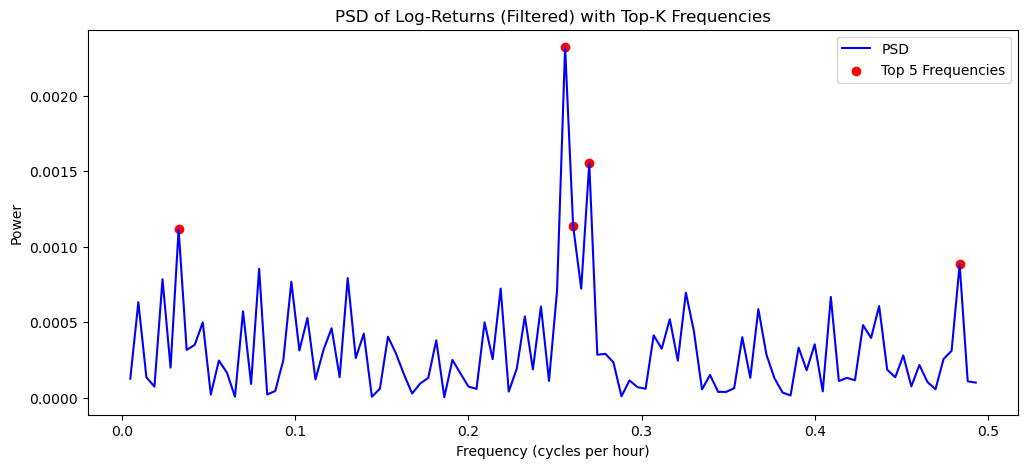

Fourier features shape: (215, 10)
Combined feature matrix shape: (215, 11)
Sequence shape: (203, 12, 11) Target shape: (203,)
Epoch [10/200], Loss: 0.001180
Epoch [20/200], Loss: 0.000476
Epoch [30/200], Loss: 0.000321
Epoch [40/200], Loss: 0.000320
Epoch [50/200], Loss: 0.000313
Epoch [60/200], Loss: 0.000301
Epoch [70/200], Loss: 0.000294
Epoch [80/200], Loss: 0.000289
Epoch [90/200], Loss: 0.000286
Epoch [100/200], Loss: 0.000284
Epoch [110/200], Loss: 0.000282
Epoch [120/200], Loss: 0.000280
Epoch [130/200], Loss: 0.000278
Epoch [140/200], Loss: 0.000276
Epoch [150/200], Loss: 0.000275
Epoch [160/200], Loss: 0.000273
Epoch [170/200], Loss: 0.000271
Epoch [180/200], Loss: 0.000270
Epoch [190/200], Loss: 0.000268
Epoch [200/200], Loss: 0.000266

Test MSE Loss (Log-Returns): 0.000199


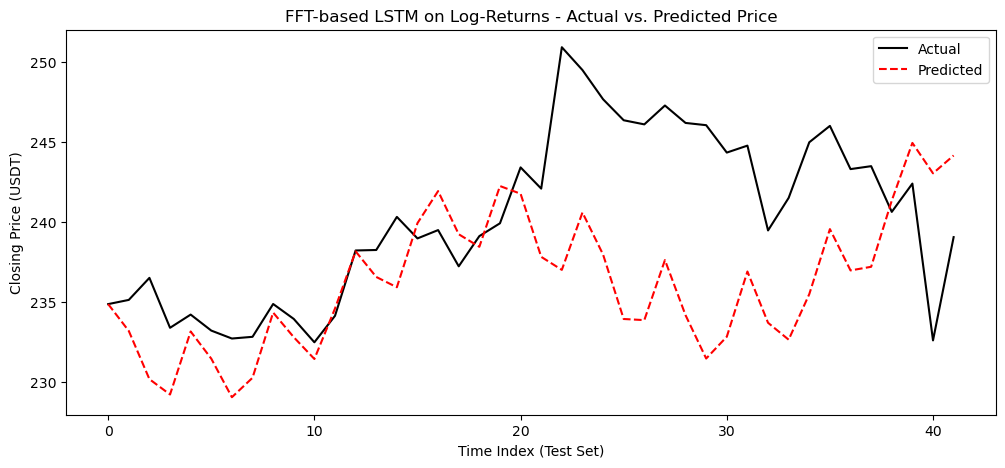

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.signal import find_peaks

# ===============================
# 1. Load Dataset
# ===============================
file_path = "AAVE_ohlcv_data.csv"  # Adjust if needed
df = pd.read_csv(file_path)

# Convert timestamp and sort chronologically
df["timestamp"] = pd.to_datetime(df["timestamp"], errors='coerce')
df = df.sort_values("timestamp").reset_index(drop=True)

# Extract raw price
raw_price = df["price"].dropna().values
if len(raw_price) < 2:
    raise ValueError("Not enough price data for log-returns.")

# ===============================
# 2. Compute Log-Returns
# ===============================
# log_price[t] = log(raw_price[t])
# log_returns[t] = log_price[t] - log_price[t-1]
log_price = np.log(raw_price)
log_returns = np.diff(log_price)  # length N-1 if raw_price has length N
N = len(log_returns)

mean_returns = np.mean(log_returns)
stationary_returns = log_returns - mean_returns  # remove DC component if desired

# ===============================
# 3. Compute FFT & PSD on Log-Returns
# ===============================
fft_result = np.fft.fft(stationary_returns)
frequencies = np.fft.fftfreq(N, d=1)  # assuming 1-hour intervals
psd = (np.abs(fft_result) ** 2) / N

# Only positive frequencies
pos_freqs = frequencies[:N // 2]
pos_psd = psd[:N // 2]

# ===============================
# 4. Filter Out Very Low Frequencies
# ===============================
freq_threshold = 0.0005  # Example threshold, skip frequencies below this
mask = (pos_freqs > freq_threshold)
filtered_freqs = pos_freqs[mask]
filtered_psd = pos_psd[mask]

# ===============================
# 5. Select Top K Frequencies
# ===============================
K = 5
sorted_indices = np.argsort(-filtered_psd)  # sort descending
top_k_indices = sorted_indices[:K]
dominant_freqs = filtered_freqs[top_k_indices]
dominant_psd = filtered_psd[top_k_indices]

print(f"Top {K} Frequencies (cycles/hour):", dominant_freqs)

# (Optional) Plot the PSD
plt.figure(figsize=(12, 5))
plt.plot(filtered_freqs, filtered_psd, label="PSD", color="blue")
plt.scatter(dominant_freqs, dominant_psd, color="red", label=f"Top {K} Frequencies")
plt.xlabel("Frequency (cycles per hour)")
plt.ylabel("Power")
plt.title("PSD of Log-Returns (Filtered) with Top-K Frequencies")
plt.legend()
plt.show()

# ===============================
# 6. Create Fourier Features
# ===============================
time_indices = np.arange(N)  # 0..N-1 for log_returns
fourier_feats = []

for f in dominant_freqs:
    sin_feat = np.sin(2 * np.pi * f * time_indices)
    cos_feat = np.cos(2 * np.pi * f * time_indices)
    fourier_feats.append(sin_feat)
    fourier_feats.append(cos_feat)

if fourier_feats:
    fourier_feats = np.stack(fourier_feats, axis=1)  # shape (N, 2*K)
else:
    fourier_feats = np.zeros((N, 0))

print("Fourier features shape:", fourier_feats.shape)

# We'll also include the raw log_returns as a feature
log_returns_feat = log_returns.reshape(-1, 1)  # shape (N,1)
X_features = np.concatenate([log_returns_feat, fourier_feats], axis=1)
print("Combined feature matrix shape:", X_features.shape)

# ===============================
# 7. Create Sequences for LSTM
# ===============================
# We'll predict the next log-return: log_returns[t+1] from the past window_size steps
window_size = 12

def create_sequences(X, y, window):
    X_seq, y_seq = [], []
    for i in range(len(X) - window):
        X_seq.append(X[i : i+window])
        y_seq.append(y[i + window])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_features, log_returns, window_size)
print("Sequence shape:", X_seq.shape, "Target shape:", y_seq.shape)

# ===============================
# 8. Time-Based Split
# ===============================
split_idx = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# ===============================
# 9. Define LSTM Model
# ===============================
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return out

input_dim = X_features.shape[1]  # (1 + 2*K)
hidden_dim = 36
num_layers = 2
output_dim = 1

model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ===============================
# 10. Train the LSTM
# ===============================
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")

# ===============================
# 11. Evaluate the Model
# ===============================
model.eval()
with torch.no_grad():
    preds_test = model(X_test_tensor)
    test_loss = criterion(preds_test, y_test_tensor).item()
    print(f"\nTest MSE Loss (Log-Returns): {test_loss:.6f}")

preds_test_np = preds_test.numpy().flatten()
y_test_np = y_test.flatten()

# ===============================
# 12. Reconstruct Price from Log-Returns
# ===============================
# We'll start from the last known log_price before the test set.
# Because log_returns[t] = log_price[t] - log_price[t-1],
# we can do a cumulative sum to get the predicted log_price sequence.

# The last train index in raw_price is (len(log_returns)), so log_price[len(log_returns)] is the final train log price
last_train_log_price = log_price[window_size + split_idx]  # approximate reference
# We'll build the predicted log_prices in the test set by cumulatively summing from that reference.

predicted_log_prices = [last_train_log_price]
for r in preds_test_np:
    next_log_price = predicted_log_prices[-1] + r
    predicted_log_prices.append(next_log_price)

# We'll do the same for actual log-returns to get the actual log_price
actual_log_prices = [last_train_log_price]
for r in y_test_np:
    next_log_price = actual_log_prices[-1] + r
    actual_log_prices.append(next_log_price)

# Convert log_prices to raw prices
preds_price = np.exp(predicted_log_prices)
actual_price = np.exp(actual_log_prices)

# Because we built these sequences cumulatively, they have length = len(preds_test) + 1
# We'll drop the first point for better alignment, or keep them as is for visualization

# ===============================
# 13. Plot Actual vs. Predicted in Original Scale
# ===============================
plt.figure(figsize=(12, 5))
plt.plot(actual_price, label="Actual", color="black")
plt.plot(preds_price, label="Predicted", linestyle="--", color="red")
plt.title("FFT-based LSTM on Log-Returns - Actual vs. Predicted Price")
plt.xlabel("Time Index (Test Set)")
plt.ylabel("Closing Price (USDT)")
plt.legend()
plt.show()


OLS RMSE on test set (log-returns): 0.012769


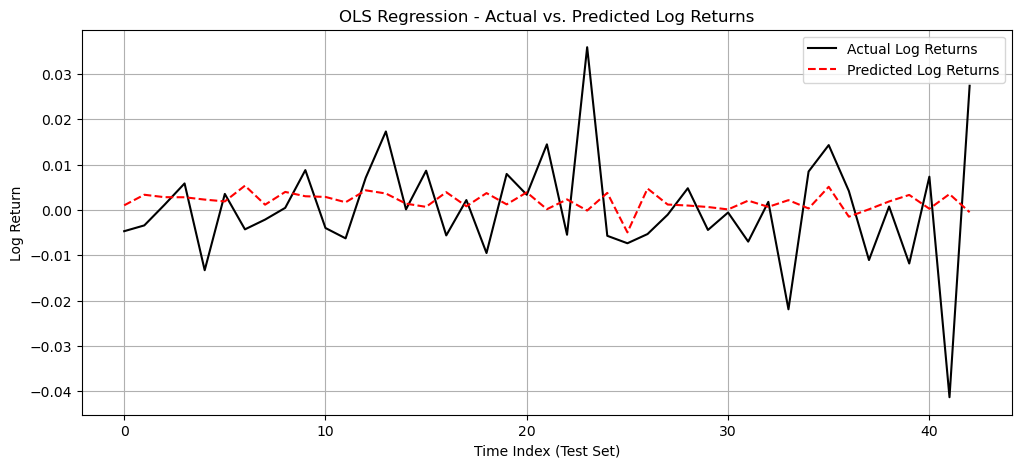

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# ===============================
# 1. Load and preprocess data
# ===============================
df = pd.read_csv("AAVE_ohlcv_data.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df = df.sort_values("timestamp").reset_index(drop=True)

log_price = np.log(df["price"].dropna().values)
log_returns = np.diff(log_price)

# ===============================
# 2. Create lagged features
# ===============================
def create_lag_features(series, lags=3):
    X = []
    y = []
    for i in range(lags, len(series) - 1):
        X.append(series[i - lags:i])
        y.append(series[i + 1] - series[i])  # log return
    return np.array(X), np.array(y)

lags = 3
X, y = create_lag_features(log_price, lags)

# ===============================
# 3. Train-test split (80/20)
# ===============================
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# ===============================
# 4. OLS Model
# ===============================
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"OLS RMSE on test set (log-returns): {rmse:.6f}")

# ===============================
# 5. Plot
# ===============================
plt.figure(figsize=(12, 5))
plt.plot(y_test, label="Actual Log Returns", color="black")
plt.plot(y_pred, label="Predicted Log Returns", linestyle="--", color="red")
plt.title("OLS Regression - Actual vs. Predicted Log Returns")
plt.xlabel("Time Index (Test Set)")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.show()


RMSE (log-price): 0.021455
RMSE (raw price): 5.1512 USDT


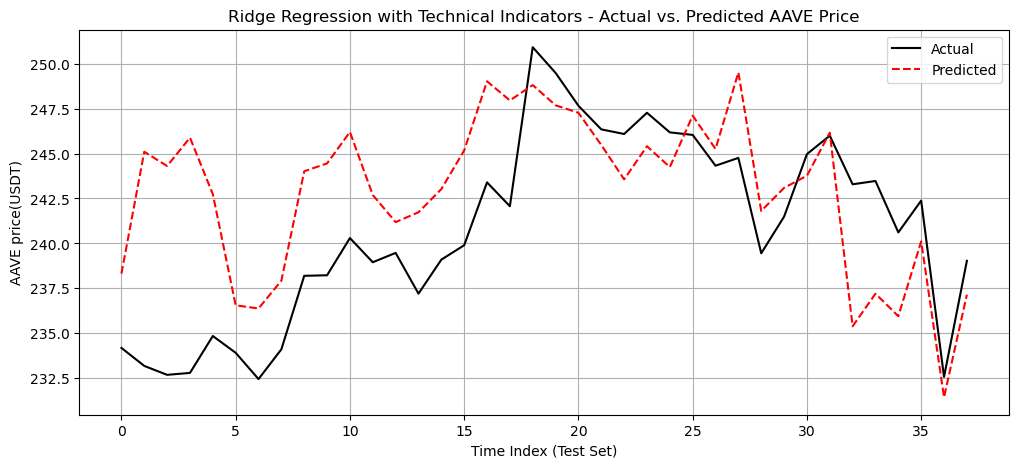

In [33]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ===============================
# 1. Load and Prepare Dataset
# ===============================
df = pd.read_csv("AAVE_ohlcv_data.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"], errors='coerce')
df = df.sort_values("timestamp").dropna(subset=["price", "market_cap", "total_volume"]).reset_index(drop=True)

# ===============================
# 2. Compute Log-Transforms
# ===============================
df["log_price"] = np.log(df["price"])
df["log_market_cap"] = np.log(df["market_cap"])
df["log_volume"] = np.log(df["total_volume"])

# ===============================
# 3. Technical Indicators
# ===============================

# SMA & EMA
df["sma_10"] = df["price"].rolling(window=10).mean()
df["sma_30"] = df["price"].rolling(window=30).mean()
df["ema_10"] = df["price"].ewm(span=10, adjust=False).mean()
df["ema_30"] = df["price"].ewm(span=30, adjust=False).mean()

# Volatility (Rolling Std)
df["volatility_10"] = df["price"].rolling(window=10).std()

# RSI (Relative Strength Index)
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=window).mean()
    avg_loss = pd.Series(loss).rolling(window=window).mean()
    rs = avg_gain / (avg_loss + 1e-8)
    rsi = 100 - (100 / (1 + rs))
    return rsi

df["rsi_14"] = compute_rsi(df["price"])

# Drop rows with NaNs caused by rolling windows
df = df.dropna().reset_index(drop=True)

# ===============================
# 4. Feature Matrix
# ===============================
features = [
    "log_volume", "rsi_14",
    "volatility_10", "sma_30"
  
]
X = df[features].values
y = df["log_price"].values

# ===============================
# 5. Train-Test Split (80/20)
# ===============================
split_index = int(0.8 * len(df))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# ===============================
# 6. Ridge Regression Model
# ===============================
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

# ===============================
# 7. Evaluate Performance
# ===============================
actual_raw_price = np.exp(y_test)
pred_raw_price = np.exp(y_pred)

rmse_raw = np.sqrt(mean_squared_error(actual_raw_price, pred_raw_price))
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"RMSE (log-price): {rmse_log:.6f}")
print(f"RMSE (raw price): {rmse_raw:.4f} USDT")

# ===============================
# 8. Visualization
# ===============================
plt.figure(figsize=(12, 5))
plt.plot(actual_raw_price, label="Actual", color="black")
plt.plot(pred_raw_price, label="Predicted", linestyle="--", color="red")
plt.title("Ridge Regression with Technical Indicators - Actual vs. Predicted AAVE Price")
plt.xlabel("Time Index (Test Set)")
#plt.yscale("log")
plt.ylabel("AAVE price(USDT)")
plt.legend()
plt.grid(True)
plt.show()


Sequence shape: (204, 12, 1) Target shape: (204, 1)
Epoch 50/500, Loss: 0.027930
Epoch 100/500, Loss: 0.010184
Epoch 150/500, Loss: 0.008738
Epoch 200/500, Loss: 0.007098
Epoch 250/500, Loss: 0.005646
Epoch 300/500, Loss: 0.005323
Epoch 350/500, Loss: 0.004477
Epoch 400/500, Loss: 0.004317
Epoch 450/500, Loss: 0.004147
Epoch 500/500, Loss: 0.003669
LSTM Without FFT - RMSE (raw price): 4.4583 USDT


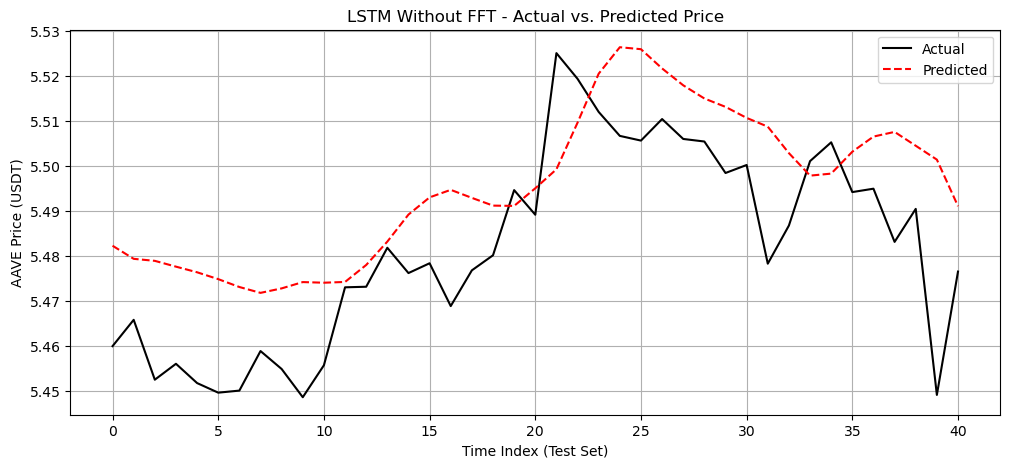

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim

# ===============================
# 1. Load and Prepare Dataset
# ===============================
df = pd.read_csv("AAVE_ohlcv_data.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"], errors='coerce')
df = df.sort_values("timestamp").reset_index(drop=True)

# Use log-transformed price to stabilize variance
log_price = np.log(df["price"].dropna().values).reshape(-1, 1)

# Normalize log-price
scaler = MinMaxScaler()
log_price_scaled = scaler.fit_transform(log_price)

# ===============================
# 2. Create LSTM Sequences
# ===============================
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 12
X_seq, y_seq = create_sequences(log_price_scaled, window_size)
print("Sequence shape:", X_seq.shape, "Target shape:", y_seq.shape)

# Split 80/20
split_idx = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# ===============================
# 3. Define LSTM Model
# ===============================
class LSTMOnly(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMOnly, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

input_dim = 1
hidden_dim = 64
num_layers = 3
output_dim = 1

model = LSTMOnly(input_dim, hidden_dim, num_layers, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ===============================
# 4. Train the Model
# ===============================
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}")

# ===============================
# 5. Evaluate and Plot
# ===============================
model.eval()
with torch.no_grad():
    pred_test = model(X_test_tensor).numpy()

# Inverse transform
pred_log_price = scaler.inverse_transform(pred_test)
actual_log_price = scaler.inverse_transform(y_test)

raw_pred = np.exp(pred_log_price.flatten())
raw_actual = np.exp(actual_log_price.flatten())

rmse_raw = np.sqrt(mean_squared_error(raw_actual, raw_pred))
print(f"LSTM Without FFT - RMSE (raw price): {rmse_raw:.4f} USDT")

# Plot
plt.figure(figsize=(12, 5))
plt.plot(actual_log_price, label="Actual", color="black")
plt.plot(pred_log_price, label="Predicted", linestyle="--", color="red")
plt.title("LSTM Without FFT - Actual vs. Predicted Price")
plt.xlabel("Time Index (Test Set)")
plt.ylabel("AAVE Price (USDT)")
plt.legend()
plt.grid(True)
plt.show()


Top 5 Dominant Frequencies (cycles/hour): [0.25581395 0.26976744 0.26046512 0.03255814 0.48372093]


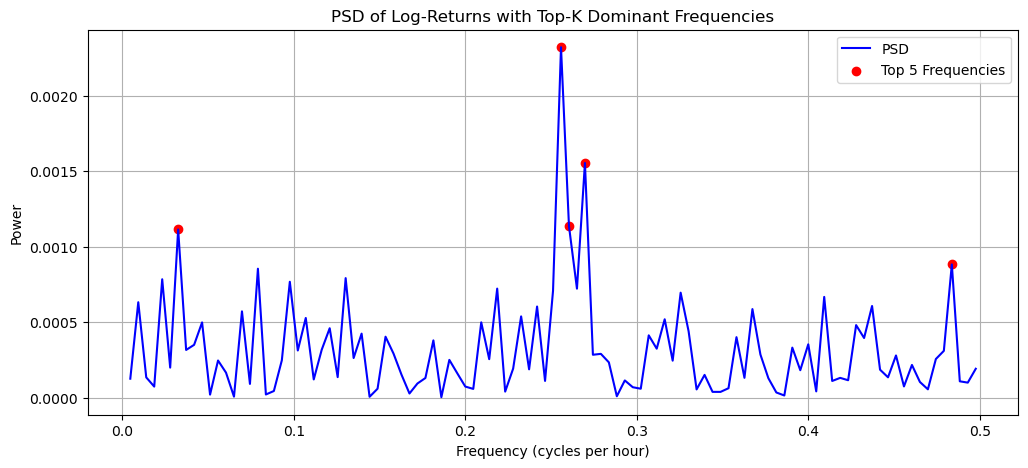

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===============================
# 1. Load the dataset
# ===============================
df = pd.read_csv("AAVE_ohlcv_data.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df = df.sort_values("timestamp").reset_index(drop=True)

# ===============================
# 2. Compute Log Returns
# ===============================
raw_price = df["price"].dropna().values

if len(raw_price) < 2:
    raise ValueError("Not enough price data to compute log-returns!")

log_price = np.log(raw_price)
log_returns = np.diff(log_price)

if len(log_returns) == 0:
    raise ValueError("Log returns are empty. Check your input data.")

# ===============================
# 3. FFT + PSD Calculation
# ===============================
N = len(log_returns)
mean_centered = log_returns - np.mean(log_returns)

fft_result = np.fft.fft(mean_centered)
frequencies = np.fft.fftfreq(N, d=1)  # d=1 for hourly interval
psd = (np.abs(fft_result) ** 2) / N

# ===============================
# 4. Filter and Extract Top Frequencies
# ===============================
pos_mask = frequencies > 0
filtered_freqs = frequencies[pos_mask]
filtered_psd = psd[pos_mask]

# Optional: Filter out very low frequencies
freq_threshold = 0.0005
valid_mask = filtered_freqs > freq_threshold
filtered_freqs = filtered_freqs[valid_mask]
filtered_psd = filtered_psd[valid_mask]

# Select Top K
K = 5
sorted_indices = np.argsort(-filtered_psd)
top_k_indices = sorted_indices[:K]
dominant_freqs = filtered_freqs[top_k_indices]
dominant_psd = filtered_psd[top_k_indices]

print(f"Top {K} Dominant Frequencies (cycles/hour):", dominant_freqs)

# ===============================
# 5. Plot the PSD
# ===============================
plt.figure(figsize=(12, 5))
plt.plot(filtered_freqs, filtered_psd, label="PSD", color="blue")
plt.scatter(dominant_freqs, dominant_psd, color="red", label=f"Top {K} Frequencies")
plt.xlabel("Frequency (cycles per hour)")
plt.ylabel("Power")
plt.title("PSD of Log-Returns with Top-K Dominant Frequencies")
plt.legend()
plt.grid(True)
plt.show()


Epoch 50/300, Loss: 0.002240
Epoch 100/300, Loss: 0.001754
Epoch 150/300, Loss: 0.001501
Epoch 200/300, Loss: 0.001570
Epoch 250/300, Loss: 0.001257
Epoch 300/300, Loss: 0.001145


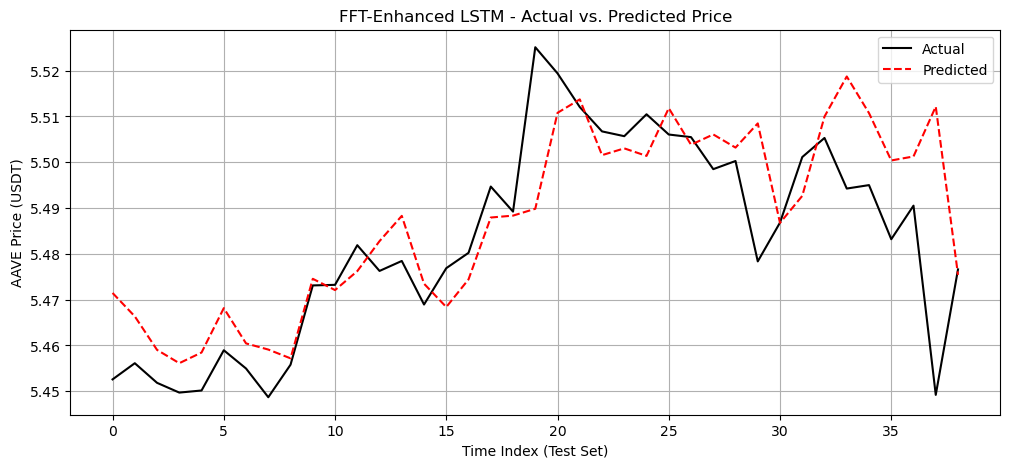

RMSE (raw price): 0.0152 USDT


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

# Load and Prepare Data
df = pd.read_csv("AAVE_ohlcv_data.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp").reset_index(drop=True)
log_price = np.log(df["price"].dropna().values).reshape(-1, 1)
log_returns = np.diff(log_price, axis=0)
log_returns = np.vstack([log_returns[0], log_returns])

# FFT Feature Extraction
N = len(log_returns)
stationary_returns = log_returns - np.mean(log_returns)
fft_result = np.fft.fft(stationary_returns.flatten())
frequencies = np.fft.fftfreq(N)
psd = (np.abs(fft_result)**2) / N
pos_freqs, pos_psd = frequencies[:N//2], psd[:N//2]
mask = pos_freqs > 0.0005
filtered_freqs, filtered_psd = pos_freqs[mask], pos_psd[mask]
K = 5
top_k_idx = np.argsort(-filtered_psd)[:K]
dominant_freqs = filtered_freqs[top_k_idx]

# Construct Fourier Features
time_indices = np.arange(N)
fourier_feats = [np.sin(2 * np.pi * f * time_indices) for f in dominant_freqs]
fourier_feats += [np.cos(2 * np.pi * f * time_indices) for f in dominant_freqs]
fourier_feats = np.stack(fourier_feats, axis=1)

# Combine all features
X_features = np.concatenate([log_price, log_returns, fourier_feats], axis=1)
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_features)
scaler_y = MinMaxScaler()
log_price_scaled = scaler_y.fit_transform(log_price)

# Create Sequences
def create_sequences(X, y, window=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, log_price_scaled, window=24)
split_idx = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Define Enhanced LSTM
class EnhancedLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=0.3, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

model = EnhancedLSTM(input_dim=X_scaled.shape[1], hidden_dim=64, num_layers=2, output_dim=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train
for epoch in range(300):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/300, Loss: {loss.item():.6f}")

# Evaluate
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_tensor).numpy()

y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_actual = scaler_y.inverse_transform(y_test_tensor.numpy())

# Plot
plt.figure(figsize=(12, 5))
plt.plot(y_actual, label="Actual", color="black")
plt.plot(y_pred, label="Predicted", linestyle="--", color="red")
plt.title("FFT-Enhanced LSTM - Actual vs. Predicted Price")
plt.xlabel("Time Index (Test Set)")
plt.ylabel("AAVE Price (USDT)")
plt.legend()
plt.grid(True)
plt.show()

# RMSE
rmse = np.sqrt(np.mean((y_pred - y_actual)**2))
print(f"RMSE (raw price): {rmse:.4f} USDT")


Columns: ['timestamp', 'price', 'market_cap', 'total_volume']


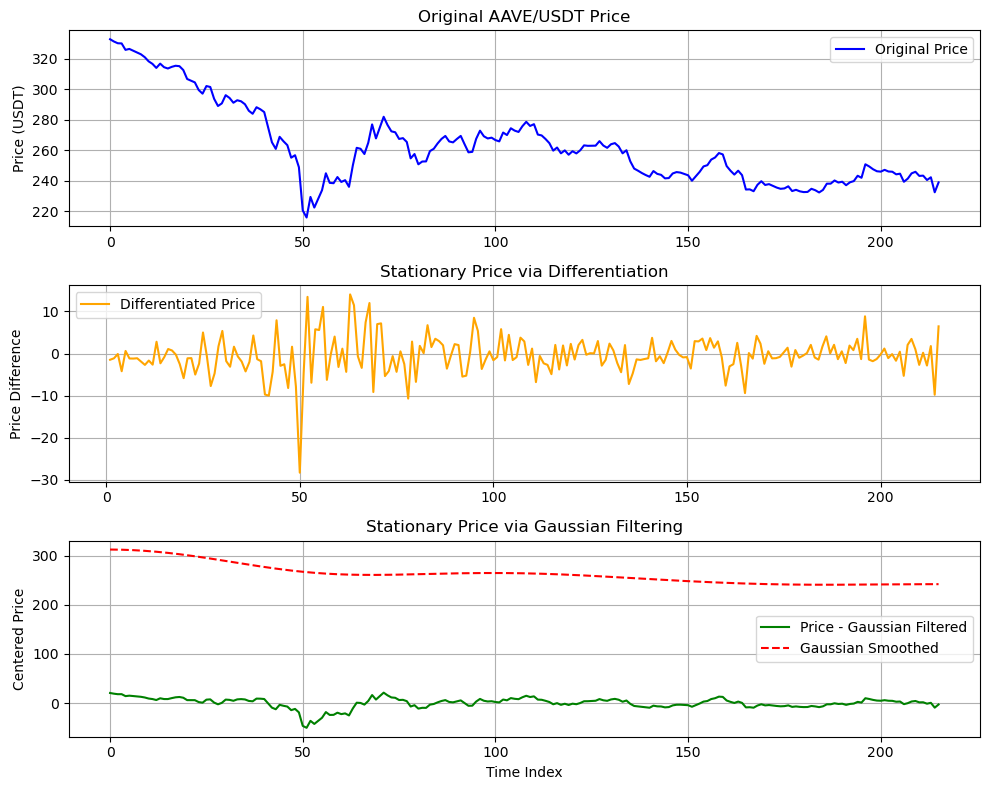

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# ===============================
# 1. Load the Dataset
# ===============================
file_path = "AAVE_ohlcv_data.csv"  # Adjust if needed
df = pd.read_csv(file_path)

# Inspect the dataset columns to ensure 'price' exists
print("Columns:", df.columns.tolist())

# Extract the price data
price = df["price"].dropna().values

# Create a time index (if you have timestamps, you can plot against them instead)
time_index = np.arange(len(price))

# ===============================
# 2. Differentiation (Derivative) Method
# ===============================
# price_diff[t] = price[t] - price[t-1]
price_diff = np.diff(price)

# For plotting, we shift the time index by 1 so the diff array lines up
time_diff = time_index[1:]

# ===============================
# 3. Gaussian Filtering Method
# ===============================
# Define a sigma (standard deviation) for the Gaussian kernel
sigma = 20  # Adjust as needed; higher sigma -> smoother result
# Smooth (filter) the price data
price_filtered = gaussian_filter1d(price, sigma=sigma)

# Compute zero-centered stationary price by subtracting the smoothed signal
price_centered = price - price_filtered

# ===============================
# 4. Plot the Results
# ===============================
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=False)

# Original Price
axes[0].plot(time_index, price, label="Original Price", color="blue")
axes[0].set_title("Original AAVE/USDT Price")
axes[0].set_ylabel("Price (USDT)")
axes[0].legend()
axes[0].grid(True)

# Derivative Method
axes[1].plot(time_diff, price_diff, label="Differentiated Price", color="orange")
axes[1].set_title("Stationary Price via Differentiation")
axes[1].set_ylabel("Price Difference")
axes[1].legend()
axes[1].grid(True)

# Gaussian Filtering & Subtraction
axes[2].plot(time_index, price_centered, label="Price - Gaussian Filtered", color="green")
axes[2].plot(time_index, price_filtered, label="Gaussian Smoothed", color="red", linestyle="--")
axes[2].set_title("Stationary Price via Gaussian Filtering")
axes[2].set_xlabel("Time Index")
axes[2].set_ylabel("Centered Price")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()


In [6]:
import requests
import pandas as pd

# Define time range: for example, from February 1, 2025 to February 10, 2025
start_date = "2025-02-01"
end_date   = "2025-02-10"

# Convert dates to Unix timestamps (in seconds)
start_timestamp = int(pd.Timestamp(start_date).timestamp())
end_timestamp   = int(pd.Timestamp(end_date).timestamp())

# CoinGecko API endpoint for market chart range data
url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart/range"

# Define parameters: vs_currency as usd, from and to timestamps
params = {
    "vs_currency": "usd",
    "from": start_timestamp,
    "to": end_timestamp
}

# Make the API request
response = requests.get(url, params=params)
print("Status Code:", response.status_code)

if response.status_code != 200:
    print("Error:", response.text)
else:
    data = response.json()
    if not data or "prices" not in data:
        print("No data returned. Try adjusting your parameters.")
    else:
        # Create DataFrames for prices, market caps, and total volumes
        df_prices = pd.DataFrame(data["prices"], columns=["timestamp", "price"])
        df_market_caps = pd.DataFrame(data["market_caps"], columns=["timestamp", "market_cap"])
        df_total_volumes = pd.DataFrame(data["total_volumes"], columns=["timestamp", "total_volume"])
        
        # Convert timestamps from milliseconds to datetime
        df_prices["timestamp"] = pd.to_datetime(df_prices["timestamp"], unit="ms")
        df_market_caps["timestamp"] = pd.to_datetime(df_market_caps["timestamp"], unit="ms")
        df_total_volumes["timestamp"] = pd.to_datetime(df_total_volumes["timestamp"], unit="ms")
        
        # Merge the dataframes on timestamp (using merge_asof for alignment)
        # Ensure data is sorted by timestamp before merging
        df_prices = df_prices.sort_values("timestamp")
        df_market_caps = df_market_caps.sort_values("timestamp")
        df_total_volumes = df_total_volumes.sort_values("timestamp")
        
        df_merged = pd.merge_asof(df_prices, df_market_caps, on="timestamp", direction="nearest")
        df_merged = pd.merge_asof(df_merged, df_total_volumes, on="timestamp", direction="nearest")
        
        # Display the first few rows of the merged dataset
        print(df_merged.head())
        
        # Optionally, save the dataset to a CSV file for further analysis
        df_merged.to_csv("BTC_ohlcv_data.csv", index=False)


Status Code: 200
                timestamp          price    market_cap  total_volume
0 2025-02-01 00:03:41.032  102404.933761  2.029227e+12  3.736614e+10
1 2025-02-01 01:03:55.213  102470.384029  2.030933e+12  4.248330e+10
2 2025-02-01 02:03:53.898  102512.466987  2.032432e+12  4.624888e+10
3 2025-02-01 03:02:18.060  102403.779773  2.031287e+12  4.604370e+10
4 2025-02-01 04:04:00.119  102249.729376  2.026640e+12  3.721985e+10


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# -------------------------------
# 1. Load and Merge Datasets
# -------------------------------
# Load AAVE dataset
aave_file = "AAVE_ohlcv_data.csv"  # Replace with your file path
aave_df = pd.read_csv(aave_file)
aave_df["timestamp"] = pd.to_datetime(aave_df["timestamp"], errors="coerce")
aave_df = aave_df.sort_values("timestamp").reset_index(drop=True)

# Load BTC dataset
btc_file = "BTC_ohlcv_data.csv"  # Replace with your BTC file
btc_df = pd.read_csv(btc_file)
btc_df["timestamp"] = pd.to_datetime(btc_df["timestamp"], errors="coerce")
btc_df = btc_df.sort_values("timestamp").reset_index(drop=True)

# Merge datasets on timestamp using merge_asof (assumes timestamps are similar)
merged_df = pd.merge_asof(aave_df, btc_df, on="timestamp", direction="nearest", suffixes=("_aave", "_btc"))
print("Merged dataset head:")
print(merged_df.head())

# -------------------------------
# 2. Compute Log-Returns for AAVE and BTC
# -------------------------------
# For AAVE:
aave_price = merged_df["price_aave"].values
aave_log_price = np.log(aave_price)
aave_log_returns = np.diff(aave_log_price)  # length = len(aave_price) - 1

# For BTC:
btc_price = merged_df["price_btc"].values
btc_log_price = np.log(btc_price)
btc_log_returns = np.diff(btc_log_price)  # length = len(btc_price) - 1

# Adjust merged_df to align with differencing (drop first row)
merged_df = merged_df.iloc[1:].reset_index(drop=True)

# -------------------------------
# 3. Generate Fourier Features from AAVE Log-Returns
# -------------------------------
N = len(aave_log_returns)
mean_aave_ret = np.mean(aave_log_returns)
stationary_aave_returns = aave_log_returns - mean_aave_ret

# Compute FFT and PSD on stationary AAVE log-returns
fft_result = np.fft.fft(stationary_aave_returns)
frequencies = np.fft.fftfreq(N, d=1)  # assuming 1-hour intervals
psd = (np.abs(fft_result) ** 2) / N

# Only take positive frequencies
pos_freqs = frequencies[:N // 2]
pos_psd = psd[:N // 2]

# Filter out very low frequencies (e.g., below 0.0005 cycles/hour)
freq_threshold = 0.0005
mask = pos_freqs > freq_threshold
filtered_freqs = pos_freqs[mask]
filtered_psd = pos_psd[mask]

# Select top K frequencies (e.g., K = 5)
K = 5
sorted_indices = np.argsort(-filtered_psd)  # sort in descending order
top_k_indices = sorted_indices[:K]
dominant_freqs = filtered_freqs[top_k_indices]
print("Dominant Frequencies (cycles/hour) from AAVE:", dominant_freqs)

# Create Fourier features (sine and cosine) for each dominant frequency over time
time_indices = np.arange(N)  # for log-returns
fourier_feats = []
for f in dominant_freqs:
    sin_feat = np.sin(2 * np.pi * f * time_indices)
    cos_feat = np.cos(2 * np.pi * f * time_indices)
    fourier_feats.append(sin_feat)
    fourier_feats.append(cos_feat)

if fourier_feats:
    fourier_feats = np.stack(fourier_feats, axis=1)  # shape: (N, 2*K)
else:
    fourier_feats = np.zeros((N, 0))

print("Fourier features shape:", fourier_feats.shape)

# For simplicity, summarize the multiple Fourier features by taking their mean along columns.
aave_fourier_summary = np.mean(fourier_feats, axis=1)  # shape (N,)

# -------------------------------
# 4. Prepare Data for Granger Causality Test
# -------------------------------
# We now have two series (both of length N):
# - aave_fourier_summary: summary of AAVE’s Fourier features (exogenous)
# - btc_log_returns: BTC log-returns (endogenous)
gc_df = pd.DataFrame({
    "aave_fourier": aave_fourier_summary,
    "btc_log_returns": btc_log_returns
}).dropna()

print("Data for Granger Causality Test:")
print(gc_df.head())

data_for_gc = gc_df.values  # shape: (n_samples, 2)

# -------------------------------
# 5. Run Granger Causality Test using causal-learn
# -------------------------------
# Import Granger from causal-learn (no max_lag parameter in constructor)
from causallearn.search.Granger.Granger import Granger

G = Granger()  # Initialize without extra parameters
# The function returns a tuple; assume the first element is the p-value matrix.
p_value_results = G.granger_test_2d(data_for_gc)
p_matrix = p_value_results[0]  # Extract the p-value matrix
coeff = G.granger_lasso(data_for_gc)

print("P-Value Matrix:")
print(p_matrix)
print("Granger Lasso Coefficients:")
print(coeff)

alpha = 0.05
if p_matrix[0, 1] < alpha:
    print(f"AAVE Fourier features Granger-cause BTC log-returns (p = {p_matrix[0,1]:.4f}).")
else:
    print(f"No significant Granger causality from AAVE Fourier features to BTC log-returns (p = {p_matrix[0,1]:.4f}).")


Merged dataset head:
                timestamp  price_aave  market_cap_aave  total_volume_aave  \
0 2025-02-01 00:03:39.884  332.819840     5.009661e+09       8.586597e+08   
1 2025-02-01 01:04:04.780  331.337853     4.987446e+09       8.610070e+08   
2 2025-02-01 02:03:45.876  330.195345     4.974029e+09       8.532744e+08   
3 2025-02-01 03:02:29.958  330.079187     4.973410e+09       8.535224e+08   
4 2025-02-01 04:03:47.078  325.863559     4.908443e+09       8.493544e+08   

       price_btc  market_cap_btc  total_volume_btc  
0  102404.933761    2.029227e+12      3.736614e+10  
1  102470.384029    2.030933e+12      4.248330e+10  
2  102512.466987    2.032432e+12      4.624888e+10  
3  102403.779773    2.031287e+12      4.604370e+10  
4  102249.729376    2.026640e+12      3.721985e+10  
Dominant Frequencies (cycles/hour) from AAVE: [0.25581395 0.26976744 0.26046512 0.03255814 0.48372093]
Fourier features shape: (215, 10)
Data for Granger Causality Test:
   aave_fourier  btc_log_ret

c:\Users\shiva\anaconda3\envs\GPU\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Columns: ['timestamp', 'price', 'market_cap', 'total_volume']


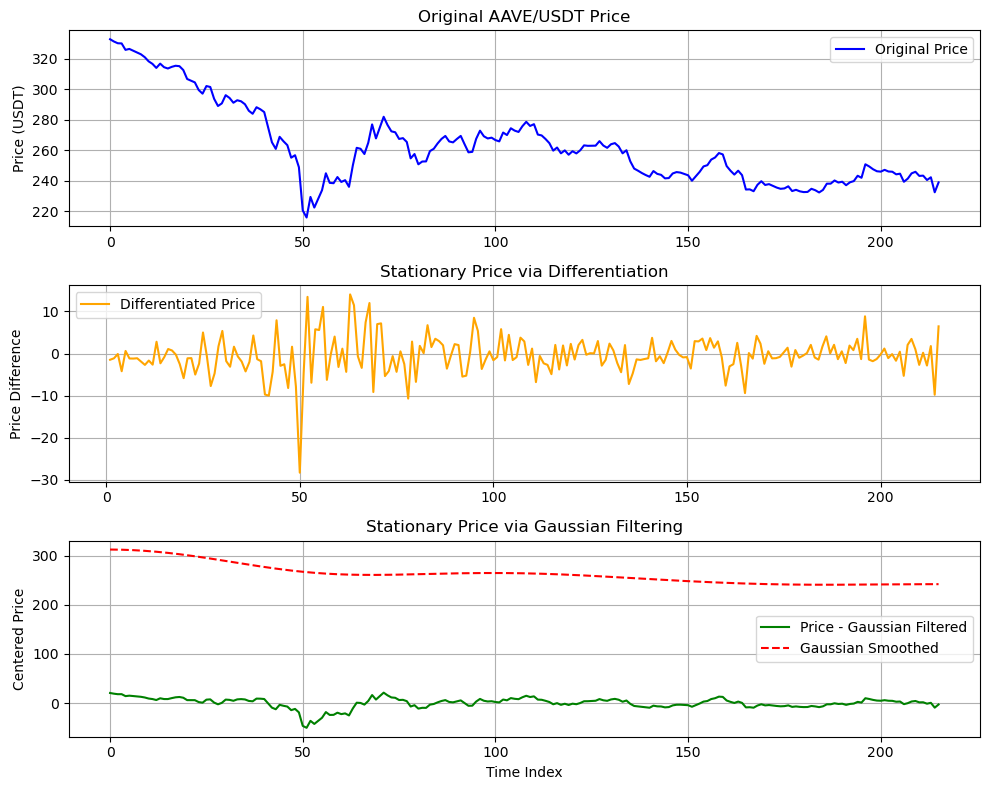

Performing FFT on Differentiated Series...

Differentiated Price - Top 5 Frequencies:
  Freq: 0.25581 cycles/sample, PSD: 146.25832
  Freq: 0.26977 cycles/sample, PSD: 91.74096
  Freq: 0.26047 cycles/sample, PSD: 74.04649
  Freq: 0.03256 cycles/sample, PSD: 70.45548
  Freq: 0.48372 cycles/sample, PSD: 56.26015


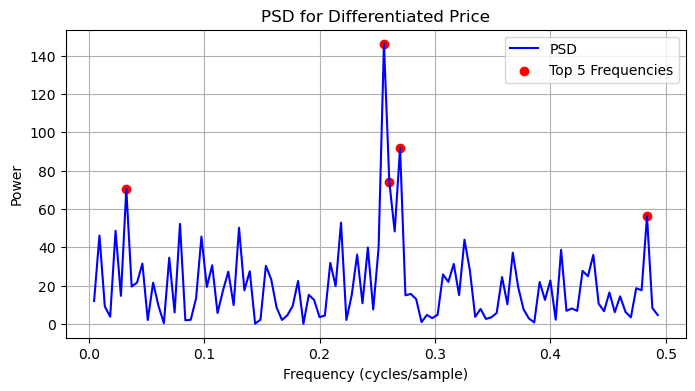

Performing FFT on Gaussian-Filtered Centered Series...

Gaussian-Filtered Centered Price - Top 5 Frequencies:
  Freq: 0.00926 cycles/sample, PSD: 3414.59530
  Freq: 0.03241 cycles/sample, PSD: 2387.77691
  Freq: 0.01389 cycles/sample, PSD: 1433.94927
  Freq: 0.02315 cycles/sample, PSD: 1387.38157
  Freq: 0.04630 cycles/sample, PSD: 557.80935


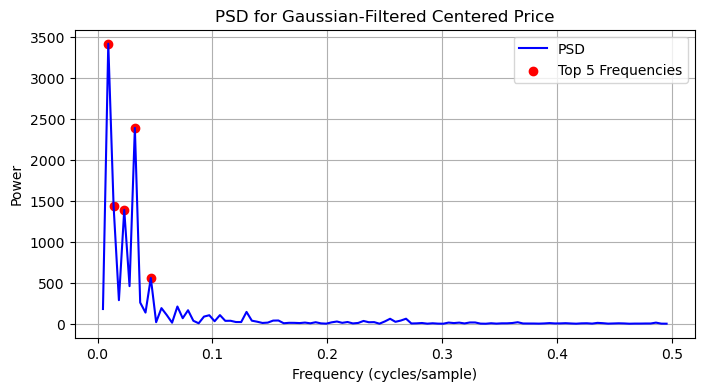

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# ===============================
# 1. Load the Dataset
# ===============================
file_path = "AAVE_ohlcv_data.csv"  # Adjust if needed
df = pd.read_csv(file_path)

# Inspect the dataset columns to ensure 'price' exists
print("Columns:", df.columns.tolist())

# Extract the price data
price = df["price"].dropna().values

# Create a time index (if you have timestamps, you can plot against them instead)
time_index = np.arange(len(price))

# ===============================
# 2. Differentiation (Derivative) Method
# ===============================
# price_diff[t] = price[t] - price[t-1]
price_diff = np.diff(price)
time_diff = time_index[1:]  # for plotting alignment

# ===============================
# 3. Gaussian Filtering Method
# ===============================
# Define a sigma (standard deviation) for the Gaussian kernel
sigma = 20  # Adjust as needed; higher sigma -> smoother result
# Smooth (filter) the price data
price_filtered = gaussian_filter1d(price, sigma=sigma)

# Compute zero-centered stationary price by subtracting the smoothed signal
price_centered = price - price_filtered

# ===============================
# 4. Plot the Original & Stationary Series
# ===============================
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=False)

# Original Price
axes[0].plot(time_index, price, label="Original Price", color="blue")
axes[0].set_title("Original AAVE/USDT Price")
axes[0].set_ylabel("Price (USDT)")
axes[0].legend()
axes[0].grid(True)

# Derivative Method
axes[1].plot(time_diff, price_diff, label="Differentiated Price", color="orange")
axes[1].set_title("Stationary Price via Differentiation")
axes[1].set_ylabel("Price Difference")
axes[1].legend()
axes[1].grid(True)

# Gaussian Filtering & Subtraction
axes[2].plot(time_index, price_centered, label="Price - Gaussian Filtered", color="green")
axes[2].plot(time_index, price_filtered, label="Gaussian Smoothed", color="red", linestyle="--")
axes[2].set_title("Stationary Price via Gaussian Filtering")
axes[2].set_xlabel("Time Index")
axes[2].set_ylabel("Centered Price")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

# ===============================
# 5. FFT & Top 5 Frequencies for Each Stationary Series
# ===============================
def compute_fft_top_frequencies(series, d=1, K=5, freq_threshold=0.0, label=""):
    """
    Computes FFT on 'series', filters out frequencies below freq_threshold,
    picks top K frequencies, and plots the PSD.
    """
    N = len(series)
    # 1. FFT
    fft_result = np.fft.fft(series)
    frequencies = np.fft.fftfreq(N, d=d)  # d=1 -> assume 1 sample per hour
    psd = (np.abs(fft_result)**2) / N
    
    # Only consider positive frequencies
    pos_freqs = frequencies[:N // 2]
    pos_psd = psd[:N // 2]
    
    # 2. Filter out frequencies below freq_threshold (optional)
    mask = pos_freqs > freq_threshold
    filtered_freqs = pos_freqs[mask]
    filtered_psd = pos_psd[mask]
    
    # 3. Select top K frequencies
    sorted_indices = np.argsort(-filtered_psd)  # descending order
    top_k = sorted_indices[:K]
    dominant_freqs = filtered_freqs[top_k]
    dominant_psd = filtered_psd[top_k]
    
    print(f"\n{label} - Top {K} Frequencies:")
    for i, freq in enumerate(dominant_freqs):
        print(f"  Freq: {freq:.5f} cycles/sample, PSD: {dominant_psd[i]:.5f}")
    
    # 4. Plot PSD
    plt.figure(figsize=(8, 4))
    plt.plot(filtered_freqs, filtered_psd, label="PSD", color="blue")
    plt.scatter(dominant_freqs, dominant_psd, color="red", label=f"Top {K} Frequencies")
    plt.title(f"PSD for {label}")
    plt.xlabel("Frequency (cycles/sample)")
    plt.ylabel("Power")
    plt.legend()
    plt.grid(True)
    plt.show()

    return dominant_freqs, dominant_psd

# --- A) FFT on Differentiated Price ---
print("Performing FFT on Differentiated Series...")
diff_freqs, diff_psd = compute_fft_top_frequencies(
    price_diff, d=1, K=5, freq_threshold=0.0, label="Differentiated Price"
)

# --- B) FFT on Gaussian-Centered Price ---
print("Performing FFT on Gaussian-Filtered Centered Series...")
centered_freqs, centered_psd = compute_fft_top_frequencies(
    price_centered, d=1, K=5, freq_threshold=0.0, label="Gaussian-Filtered Centered Price"
)
